# Analysis of ZIP code dataset
Analysis of a dataset of normalized handwritten digits, as described here: https://web.stanford.edu/~hastie/ElemStatLearn/datasets/zip.info.txt
Data available here: https://web.stanford.edu/~hastie/ElemStatLearn/data.html

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing
from IPython.display import display, HTML
from pandas.plotting import scatter_matrix
from sklearn.neighbors import KNeighborsRegressor
from sklearn import linear_model
from sklearn.metrics import mean_squared_error,log_loss,r2_score,roc_curve, roc_auc_score,auc
from sklearn.model_selection import train_test_split
import pickle
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from sklearn.metrics import confusion_matrix
import math
import sklearn.preprocessing as prep

## Basic preprocessing

In [2]:
data_train = pd.read_csv("Daten/zip.train", header=None, sep=" ")
data_test = pd.read_csv("Daten/zip.test",header=None,sep=" ")

In [3]:
print(f"NaNs in data train: {data_train.isnull().sum().sum()}") #nr of nans
print(f" Shape of data train: {data_train.shape}")
print(f"NaNs in data test: {data_test.isnull().sum().sum()}")
print(f" Shape of data test: {data_test.shape}")

NaNs in data train: 7291
 Shape of data train: (7291, 258)
NaNs in data test: 0
 Shape of data test: (2007, 257)


In [4]:
# drop NaN col in data_train
data_train.drop(columns = [257],axis = 1,inplace = True)
print(data_train.isnull().sum().sum()) #nr of nans

0


In [5]:
data_train.rename(columns = {data_train.columns[0]: "target"},inplace=True)
data_test.rename(columns = {data_test.columns[0]: "target"}, inplace = True)

In [6]:
display(data_train.head())
display(data_test.head())

,target,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
0,6.0,-1.0,-1.0,-1.0,-1.000,-1.000,-1.000,-1.000,-0.631,0.862,...,0.304,0.823,1.000,0.482,-0.474,-0.991,-1.000,-1.000,-1.000,-1.0
1,5.0,-1.0,-1.0,-1.0,-0.813,-0.671,-0.809,-0.887,-0.671,-0.853,...,-0.671,-0.671,-0.033,0.761,0.762,0.126,-0.095,-0.671,-0.828,-1.0
2,4.0,-1.0,-1.0,-1.0,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,...,-1.000,-1.000,-1.000,-0.109,1.000,-0.179,-1.000,-1.000,-1.000,-1.0
3,7.0,-1.0,-1.0,-1.0,-1.000,-1.000,-0.273,0.684,0.960,0.450,...,-0.318,1.000,0.536,-0.987,-1.000,-1.000,-1.000,-1.000,-1.000,-1.0
4,3.0,-1.0,-1.0,-1.0,-1.000,-1.000,-0.928,-0.204,0.751,0.466,...,0.466,0.639,1.000,1.000,0.791,0.439,-0.199,-0.883,-1.000,-1.0


,target,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
0,9,-1.0,-1.0,-1.0,-1.000,-1.0,-0.948,-0.561,0.148,0.384,...,-1.000,-0.908,0.430,0.622,-0.973,-1.000,-1.0,-1.0,-1.0,-1.0
1,6,-1.0,-1.0,-1.0,-1.000,-1.0,-1.000,-1.000,-1.000,-1.000,...,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.0,-1.0,-1.0,-1.0
2,3,-1.0,-1.0,-1.0,-0.593,0.7,1.000,1.000,1.000,1.000,...,1.000,0.717,0.333,0.162,-0.393,-1.000,-1.0,-1.0,-1.0,-1.0
3,6,-1.0,-1.0,-1.0,-1.000,-1.0,-1.000,-1.000,-1.000,-1.000,...,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.0,-1.0,-1.0,-1.0
4,6,-1.0,-1.0,-1.0,-1.000,-1.0,-1.000,-1.000,-0.858,-0.106,...,0.901,0.901,0.901,0.290,-0.369,-0.867,-1.0,-1.0,-1.0,-1.0


## Useful functions

In [7]:
def get_digit_rows(data,digit): 
    """returns all rows of a given digit
        careful: first column (target digit) still included!!!"""
    rows = data[data['target'] == float(digit)]
    return pd.DataFrame(rows)

display(get_digit_rows(data_train,2)) # testing the function

def print_image_observation(data,row):
    """shows the image of a specific row in data"""
    img = data.iloc[row,1:].values.reshape(16,16)  
    plt.imshow(img,cmap="jet",interpolation="nearest",vmin=0,vmax=1)
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.tight_layout()
    return None
   
#print_image_observation(data_train,3637)

def get_digit_stat_array(data,digit,stat):
    """returns the (reshaped) 16x16 image for a given digit and statistic"""
    digit_rows = get_digit_rows(data,digit).iloc[:,1:]
    if stat == "mean":
        stat_row = digit_rows.mean()
    elif stat == "sd":
        stat_row = np.std(digit_rows)
    elif stat == "max":
        stat_row = np.max(digit_rows)
    elif stat == "min":
        stat_row = np.min(digit_rows)
    else: print("please enter a valid stat (mean,sd,max or min)")
    img = stat_row.values.reshape(16,16)
    return img

#display(get_digit_stat_array(data_train,8,"mean")) # testing the function

def print_digit(data,digit,stat):
    """returns a plot showing the digit image statistic, e.g. average digit image
        colormap ranges from 0 to 1"""
    img = get_digit_stat_array(data,digit,stat)
    plt.imshow(img,cmap="jet",interpolation="nearest",vmin=0,vmax=1)
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.tight_layout()

,target,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
41,2.0,-1.0,-1.000,-1.000,-1.000,-1.000,-0.798,0.300,0.432,-0.799,...,-0.947,-0.524,0.307,0.390,0.852,0.751,0.990,0.567,-0.664,-1.000
52,2.0,-1.0,-1.000,-1.000,-1.000,-1.000,-0.638,0.222,0.706,1.000,...,-0.576,0.635,0.755,0.549,0.273,0.074,-0.083,-1.000,-1.000,-1.000
57,2.0,-1.0,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,...,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000
62,2.0,-1.0,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,...,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000
66,2.0,-1.0,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,...,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000
67,2.0,-1.0,-1.000,-1.000,-1.000,-0.772,0.463,0.200,0.750,-0.276,...,-1.000,-1.000,-1.000,-1.000,-1.000,-0.843,0.322,0.814,-0.588,-1.000
71,2.0,-1.0,-1.000,-1.000,-1.000,-0.850,0.556,1.000,0.593,-0.071,...,-1.000,-0.831,-0.392,0.592,1.000,1.000,0.767,-0.658,-1.000,-1.000
76,2.0,-1.0,-1.000,-1.000,-0.768,0.520,1.000,0.960,0.234,-0.836,...,1.000,0.978,0.434,-0.688,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000
78,2.0,-1.0,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,...,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000
79,2.0,-1.0,-1.000,-1.000,-1.000,-1.000,-0.724,-0.189,0.387,0.666,...,-0.636,0.215,0.657,1.000,0.996,0.556,0.371,-0.106,-0.796,-1.000


## Looking at the data

### Extracting stat images for all numbers & showing them all in a plot¶

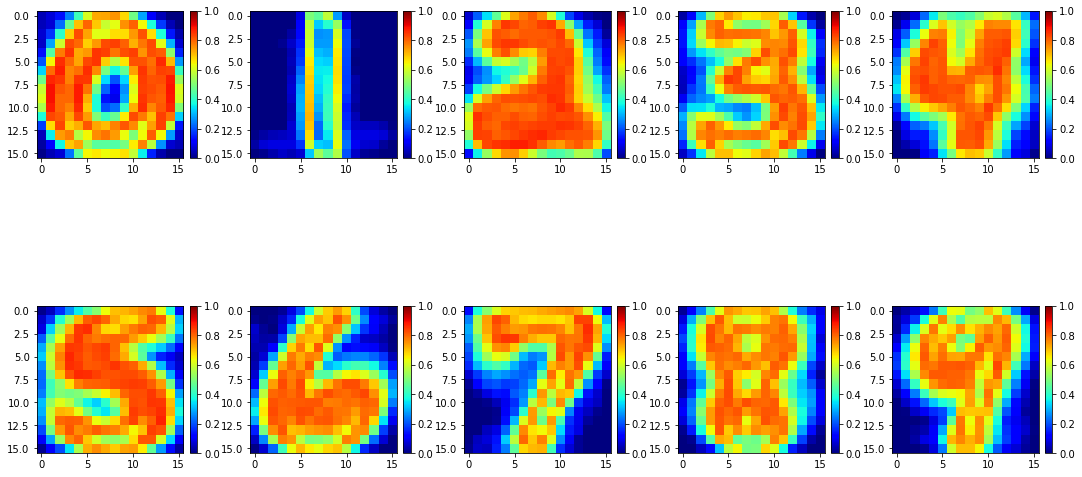

In [8]:
fig=plt.figure(figsize=(15, 15))
columns = 5
rows = 2
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    print_digit(data_train,i,"sd") # possible values for stat: "mean", "sd", "max", "min"

### Combining mean and sd image to build a 'predictive image' for each digit¶

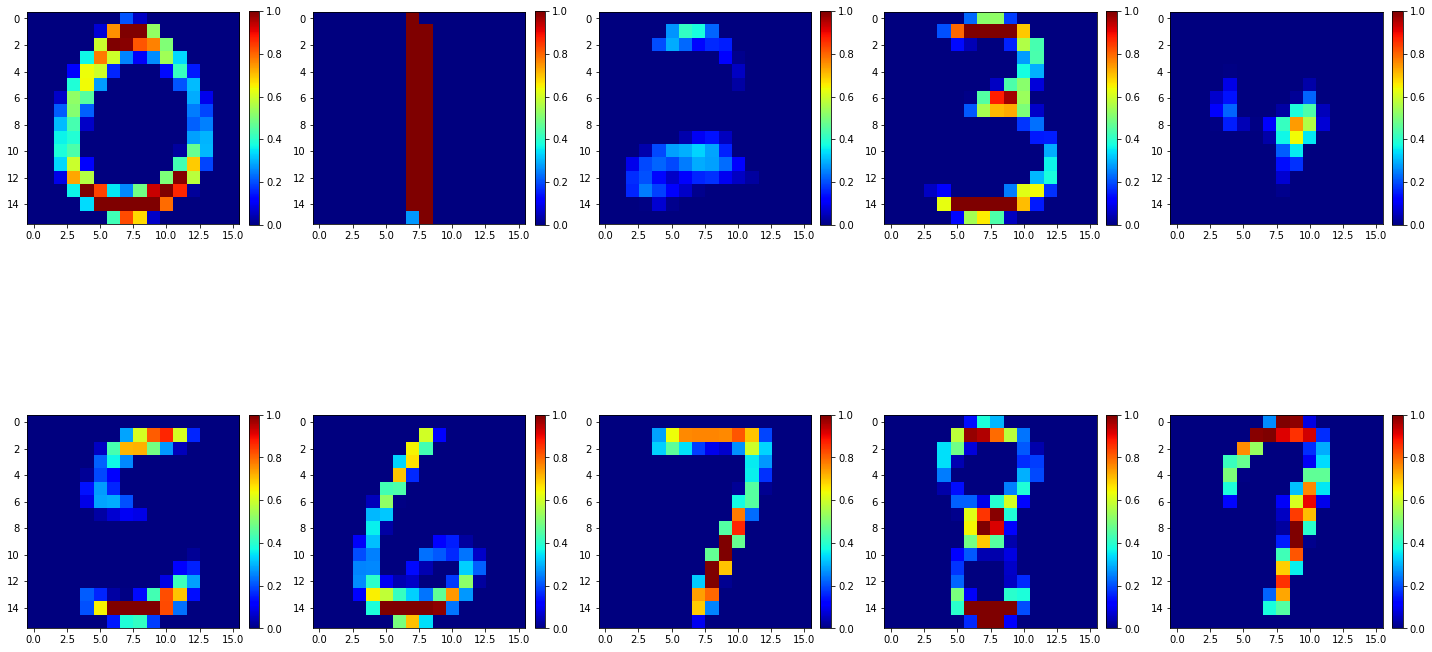

In [9]:
fig=plt.figure(figsize=(20, 20))
columns = 5
rows = 2
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    img_sd = get_digit_stat_array(data_train,i,"sd")
    img_mean = get_digit_stat_array(data_train,i,"mean")
    img_combi = img_mean/(img_sd+0.00000000000000000000001) # yes, this is not ideal :D solutions for avoiding div by zero needed
    plt.imshow(img_combi,cmap="jet",interpolation="nearest",vmin=0,vmax=1)
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.tight_layout()
plt.show()

### Summaries for each digit: mean, max, min, sd, number of observations¶

In [10]:
## For calculation of mean, max, min the mean array is used. For sd, the sd array is used. 
#NrObs = Number of observations for each digit

vals = np.zeros((5,10)) #creating an empty np_array
stats_df = pd.DataFrame(data=vals,columns = [0,1,2,3,4,5,6,7,8,9],index = ["Mean","Max","Min","SD","NrObs"])
for j in range(0,10):
    meanrow = get_digit_stat_array(data_train,j,"mean") # mean image for each digit
    sdrow = get_digit_stat_array(data_train,j,"sd")
    meanval = np.mean(meanrow)
    maxval = np.max(meanrow)
    minval = np.min(meanrow)
    sdval = np.mean(sdrow) # the mean of the sd image --> average sd
    stats_df.loc['Mean',j] = meanval 
    stats_df.loc['Max',j] = maxval
    stats_df.loc['Min',j] = minval
    stats_df.loc['SD',j] = sdval
    stats_df.loc['NrObs',j] = get_digit_rows(data_train,j).shape[0]
display(stats_df)

,0,1,2,3,4,5,6,7,8,9
Mean,-0.299005,-0.703495,-0.442712,-0.433035,-0.569881,-0.423738,-0.494621,-0.583746,-0.444284,-0.550733
Max,0.821243,0.903770,0.329394,0.723884,0.507192,0.737775,0.725901,0.724211,0.708410,0.694498
Min,-1.000000,-1.000000,-1.000000,-0.999995,-1.000000,-0.999459,-1.000000,-1.000000,-1.000000,-1.000000
SD,0.577494,0.155365,0.623708,0.541682,0.537590,0.600965,0.484779,0.415860,0.522251,0.430980
NrObs,1194.000000,1005.000000,731.000000,658.000000,652.000000,556.000000,664.000000,645.000000,542.000000,644.000000


# Unsupervised clustering
How well can the digits be classified without information about the target?

In [11]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

In [12]:
def run_cluster_analysis(prep_data):
    """does not use the first ([0]) column of prep_data!! (target col)"""
    K = KMeans(n_clusters = 10).fit(prep_data.iloc[:,1:])
    K_labels_nr = K.labels_
    G = GaussianMixture(n_components = 10, n_init = 3).fit(prep_data.iloc[:,1:])
    G_labels_nr = G.predict(prep_data.iloc[:,1:])
    K_labels = [["A","B","C","D","E","F","G","H","I","J"][nr] for nr in K_labels_nr]
    G_labels = [["A","B","C","D","E","F","G","H","I","J"][nr] for nr in G_labels_nr]
    label_df = pd.concat([data_train.iloc[:,0],pd.Series(K_labels),pd.Series(G_labels)],axis=1)
    label_df.columns = ["Target","KMeans","Gaussian"]
    label_df.Target = label_df.Target.astype(int)
    return [K,G,label_df]

def make_barplot(method,res):
    """makes two barplots: plot 1 showing the targets on the x-axis and proportions of clusters on the y-axis (i.e. 'which
    clusters was this target allocated to?') and plot 2 showing the clusters on the x-axis and proportions of targets on the
    y-axis (i.e. 'which targets are contained in this cluster?')"""
    [result_df_scaled_tar,result_df_scaled_clust,corr] = calculate_correct_rates(method,res);
    result_df_scaled_tar.plot.bar(figsize=(20,8),title = method)
    result_df_scaled_clust.T.plot.bar(figsize=(20,8),title = method)

def get_clust_rows(data,method,cluster,res):
    """returns the rows for a certain cluster and method (KMeans or Gaussian)"""
    label_df = res[2]
    cluster_rows = data[label_df[method] == cluster]
    return cluster_rows.iloc[:,1:]

def get_stat_array(data_rows,stat,res):
    """returns the (reshaped) 16x16 image for given rows (256 cols) and statistic"""
    if stat == "mean":
        stat_row = data_rows.iloc[:,0:256].mean()
    elif stat == "median":
        stat_row = data_rows.iloc[:,0:256].median()
    else: print("please enter a valid stat (mean or median)")
    img = stat_row.values.reshape(16,16)
    return img

def get_stat_array_reduced(data_rows,stat,res):
    """returns the (reshaped) 4x4 image for given rows (16 cols) and statistic"""
    if stat == "mean":
        stat_row = data_rows.iloc[:,0:16].mean()
    elif stat == "median":
        stat_row = data_rows.iloc[:,0:16].median()
    else: print("please enter a valid stat (mean or median)")
    img = stat_row.values.reshape(4,4)
    return img

def print_subplots_all_clusters(data,method,stat,res):
    """calculates the mean/median (depending on stat arg) image for the given analysis (res) and method (KMeans 
    or Gaussian) for all clusters A-J"""
    clusters = ["A","B","C","D","E","F","G","H","I","J"]
    ncols = 5
    nrows = math.ceil(len(clusters)/2)
    fig = plt.figure(figsize = (20,20)) 
    for clust in clusters:
        rows = get_clust_rows(data,method,clust,res)
        stat_img = get_stat_array(rows,stat,res)
        plt.subplot(nrows,ncols,clusters.index(clust)+1)
        plt.title(clust,fontsize = 25)
        plt.imshow(stat_img, cmap='hot', interpolation='none',vmin=-1,vmax=1)
        plt.colorbar(fraction=0.046, pad=0.04)
    plt.suptitle(method, fontsize=30,y=1.03)
    plt.tight_layout()
    plt.show()
    return None
 
def print_subplots_all_clusters_reduced(data,method,stat,res):
    clusters = ["A","B","C","D","E","F","G","H","I","J"]
    ncols = 5
    nrows = math.ceil(len(clusters)/2)
    fig = plt.figure(figsize = (20,20)) 
    for clust in clusters:
        rows = get_clust_rows(data,method,clust,res)
        stat_img = get_stat_array_reduced(rows,stat,res)
        plt.subplot(nrows,ncols,clusters.index(clust)+1)
        plt.title(clust,fontsize = 25)
        plt.imshow(stat_img, cmap='hot', interpolation='none',vmin=-1,vmax=1)
        plt.colorbar(fraction=0.046, pad=0.04)
    plt.suptitle(method, fontsize=30,y=1.03)
    plt.tight_layout()
    plt.show()

def calculate_correct_rates(method,res):
    """calculates the correctrate (as nr recognized / total nr target) for each target digit
    and the average error rate for all digits. Returns: dataframes with proportions of 
    targets ("res..clust": nr target observations/nr all observations in cluster. 
    "res..tar": nr target observations in cluster / total nr target obs); the correctrates
    if a target is split in two clusters (e.g. 0), the cluster with the highest proportion of target is 
    selected. if two targets are merged in one cluster, the target with highest prop in the cluster
    is chosen for this cluster. Other target is counted as 0% recognized
    """
    bar_data = pd.DataFrame(data = np.zeros((10,10)),columns=["A","B","C","D","E","F","G","H","I","J"])
    label_df = res[2]
    for digit in range(0,10):
        temp_result = label_df[label_df["Target"] == digit].groupby(method)["Target"].count()
        clusters_keys = temp_result.keys()
        for cluster_idx in [clusters_keys]:
            bar_data.loc[digit,cluster_idx] = temp_result[cluster_idx]
    result_df_scaled_tar = bar_data.divide(bar_data.sum(1), axis=0)
    result_df_scaled_clust = bar_data.divide(bar_data.sum(0), axis=1)
    clust_labels_real_names = []
    # finding the real name for each cluster (in res...clust)
    for clust in list(result_df_scaled_clust.columns):
        clust_labels_real_names.append(np.where(result_df_scaled_clust[clust] == result_df_scaled_clust[clust].max())[0][0])
    labelcomp_df = pd.DataFrame({method+"label": result_df_scaled_clust.columns,"recognized as": clust_labels_real_names})
    nr_recogn = labelcomp_df.groupby("recognized as").count()
    # some clusters have the same real name. finding these and deciding for one of the clusters
    # by choosing the cluster which identified the real digit more often. e.g. if real target digit 0 is
    # contained more often in cluster B than in H, cluster B is chosen
    split_tars = list(nr_recogn[nr_recogn[method+"label"] > 1].index)
    #display(split_tars) # for example series including 0 and 1 (if they are both
                                #split to several clusters)
    double_clust = labelcomp_df[method+"label"][labelcomp_df["recognized as"].isin(split_tars)]
    winner_clust,other_clust= [],[]
    for star in split_tars: # runs through all split targets and finds the cluster 
        #with the highest proportion of this target
        winner = result_df_scaled_clust.iloc[star].idxmax(axis = 1)
        winner_clust.append(winner)
        others = double_clust[double_clust!=winner].tolist()
        other_clust.append(others)
    if other_clust:
        unique_mapping = labelcomp_df[~labelcomp_df[method+"label"].isin(other_clust[0])]
    else:
        unique_mapping = labelcomp_df.copy()
    corr_rates = pd.DataFrame(data = np.zeros((11,1)),columns = [method + "label_correct"])
    for digit in range(0,10):
        corresponding_cluster = unique_mapping[method+"label"][unique_mapping["recognized as"] == digit]
        corr_rate= list(result_df_scaled_tar.loc[digit,corresponding_cluster])
        if corr_rate:
            corr_rates.iloc[digit] = corr_rate[0]
        else: corr_rates.iloc[digit] = 0
    corr_rates.iloc[10] = corr_rates.loc[0:9,method+"label_correct"].mean()
    corr_rates.rename(index={10: "Total correct"},inplace=True)
    
    return [result_df_scaled_tar,result_df_scaled_clust,corr_rates]
    
    

#display(calculate_correct_rates("Gaussian",res3)[2])

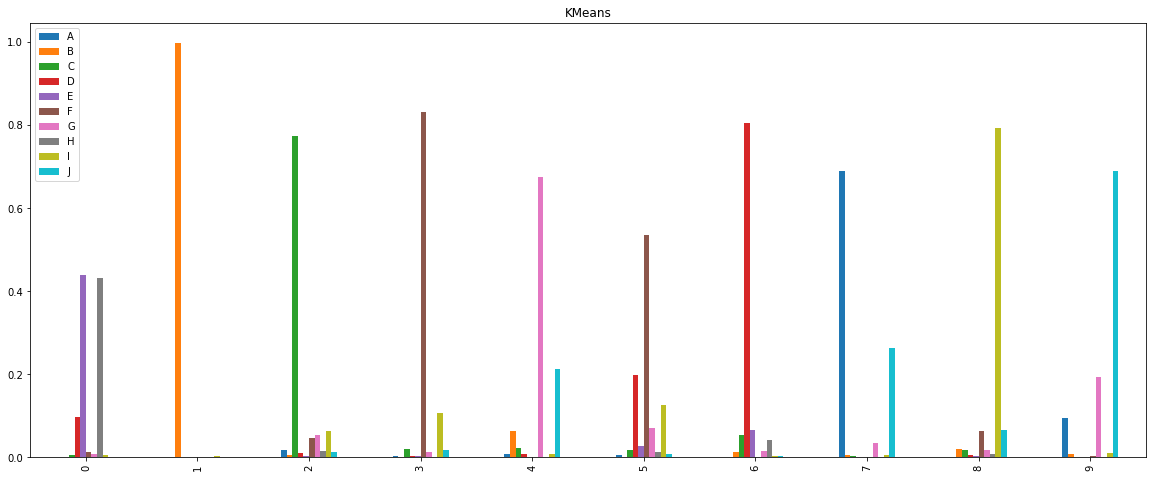

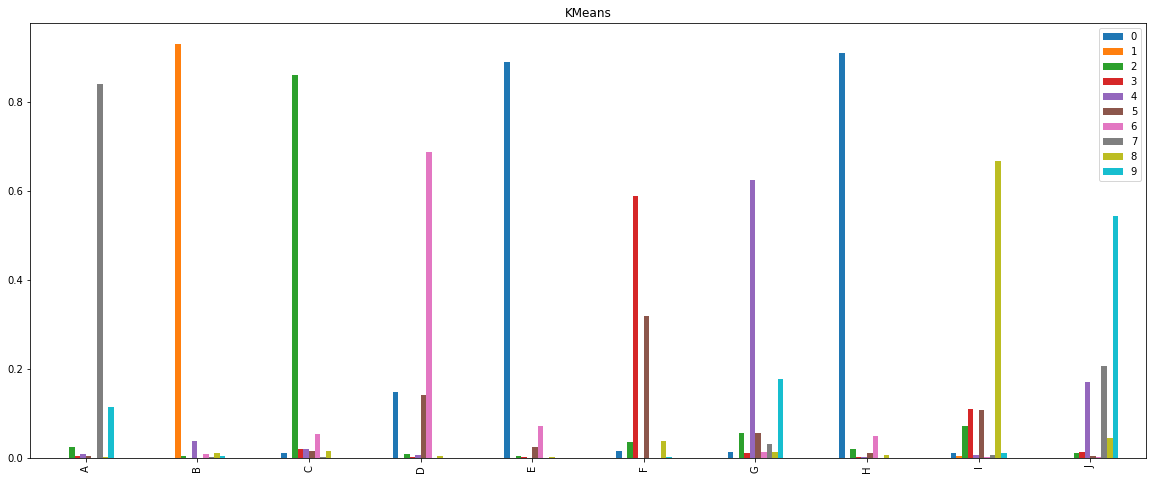

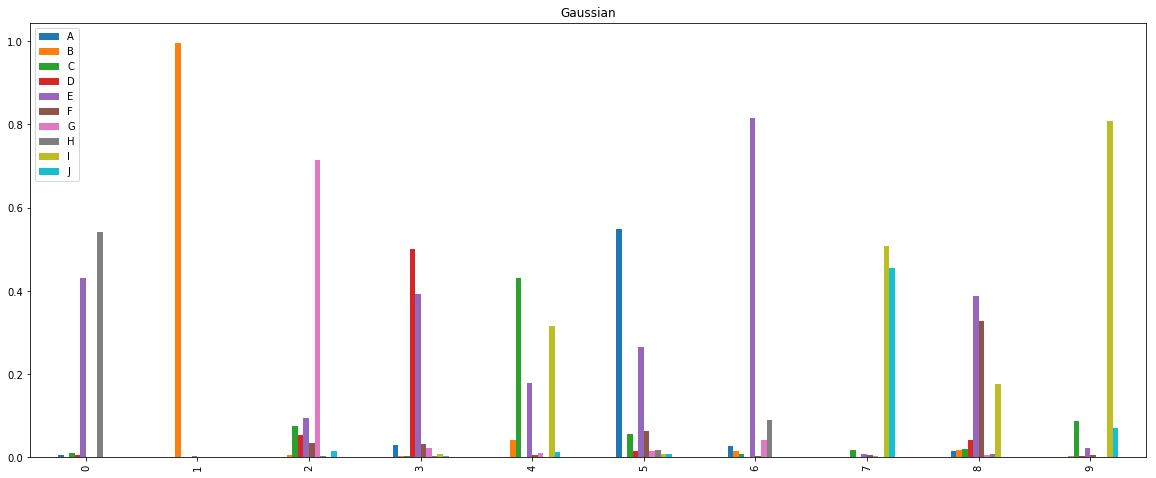

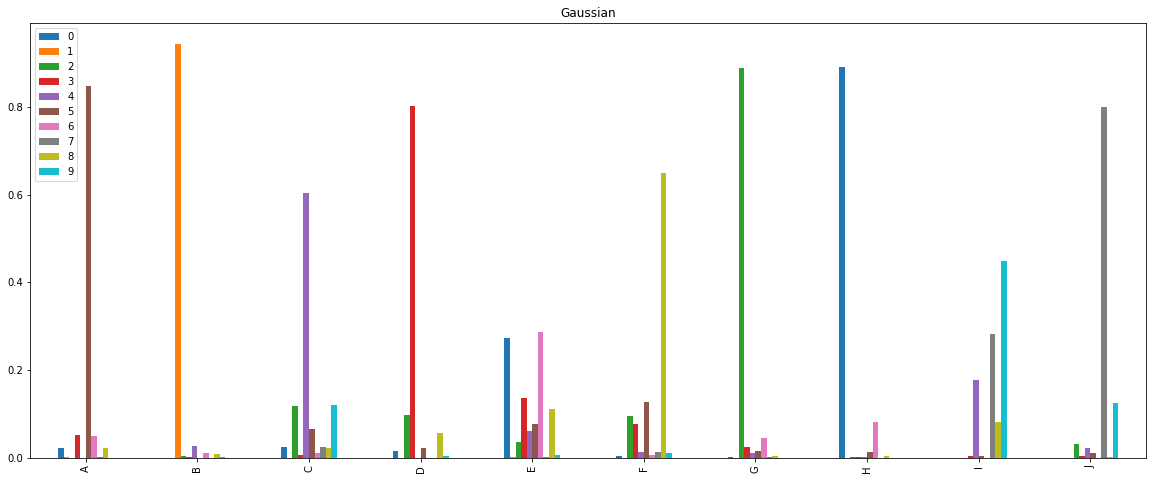

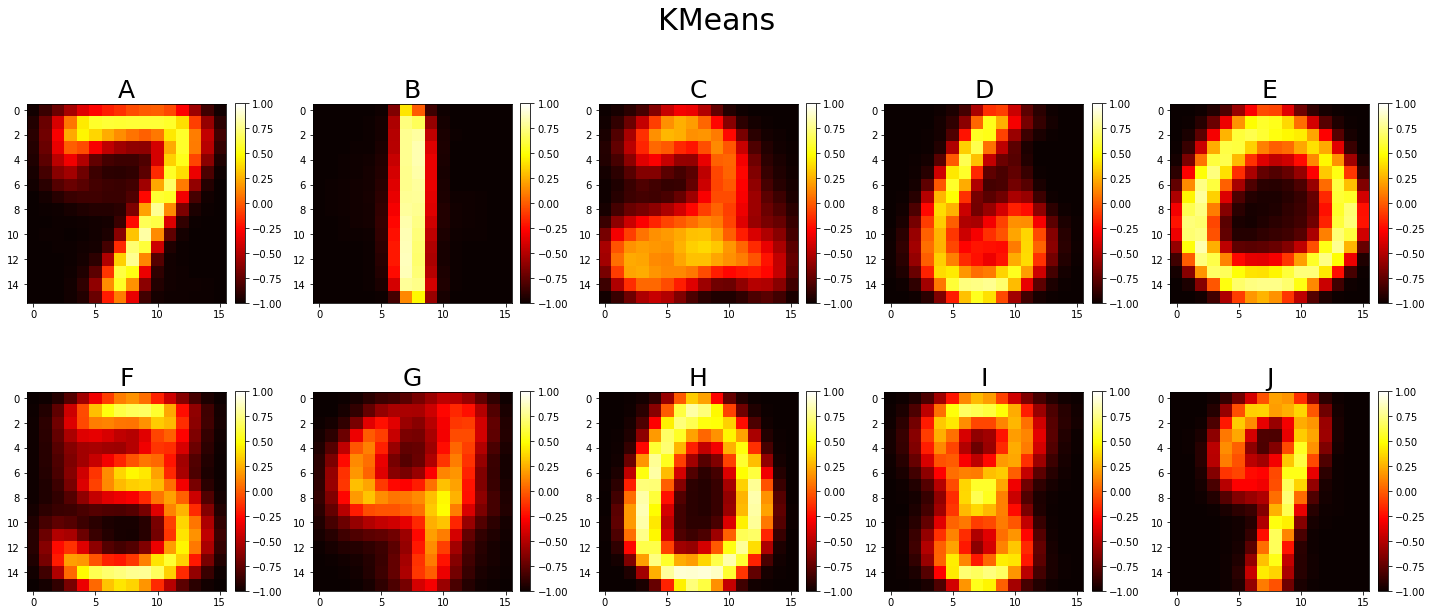

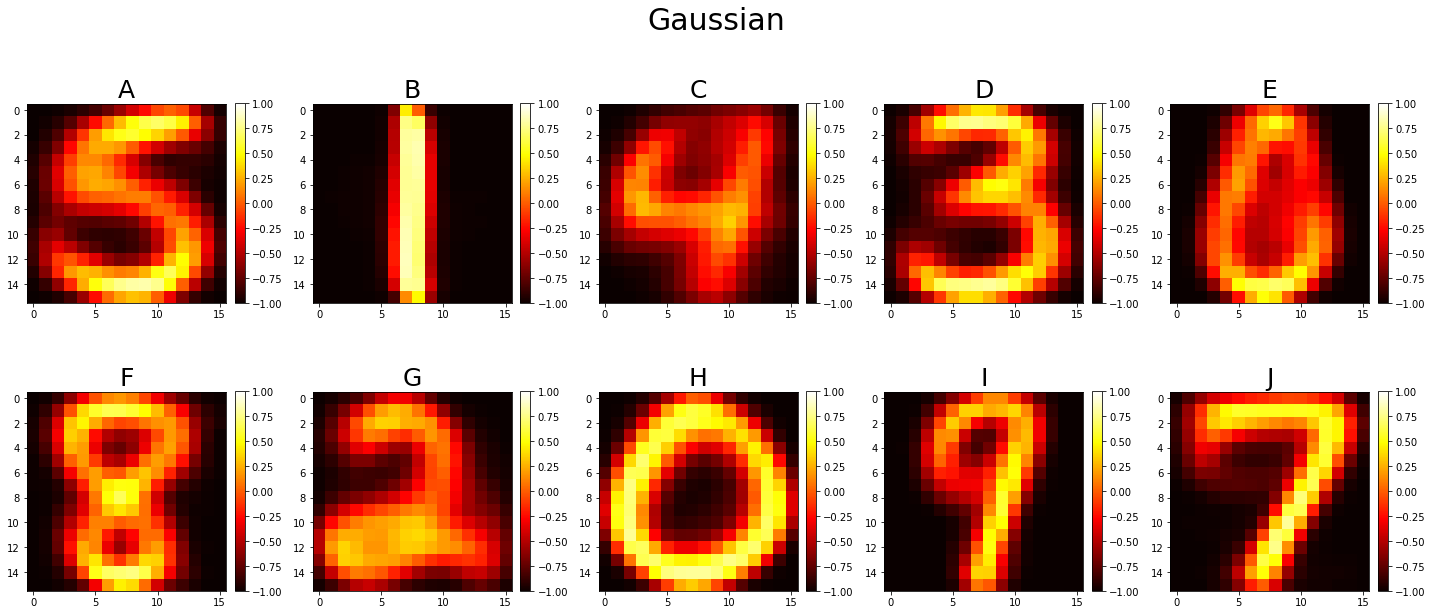

In [13]:
# clustering using only orig data
res1 = run_cluster_analysis(data_train)
make_barplot("KMeans",res1)
make_barplot("Gaussian",res1)
print_subplots_all_clusters(data_train,"KMeans","mean",res1)
print_subplots_all_clusters(data_train,"Gaussian","mean",res1)

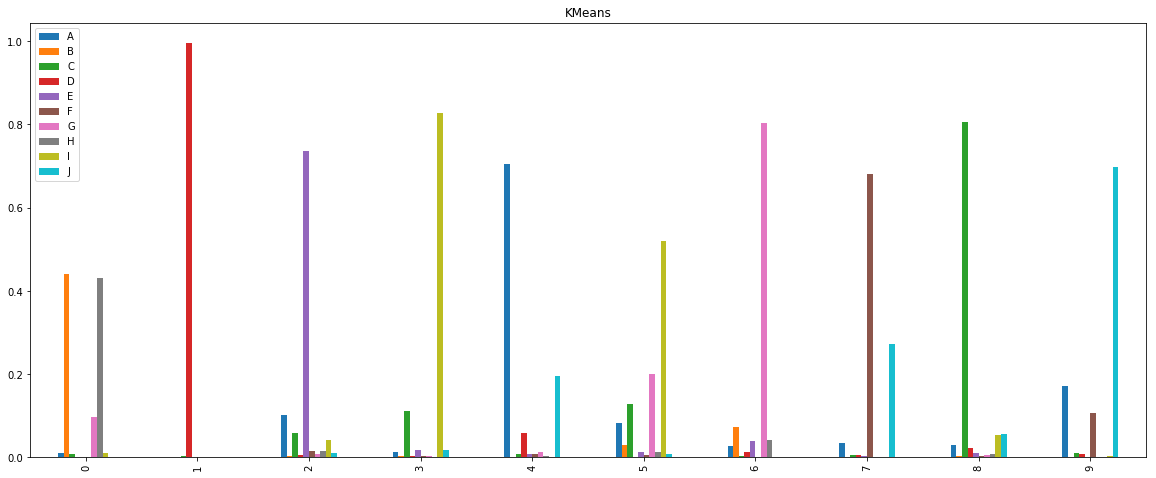

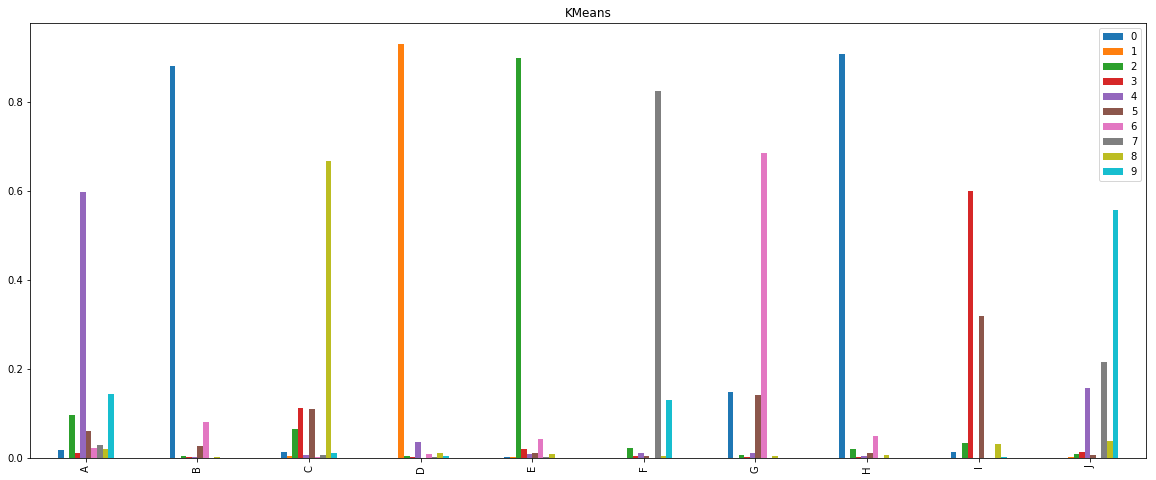

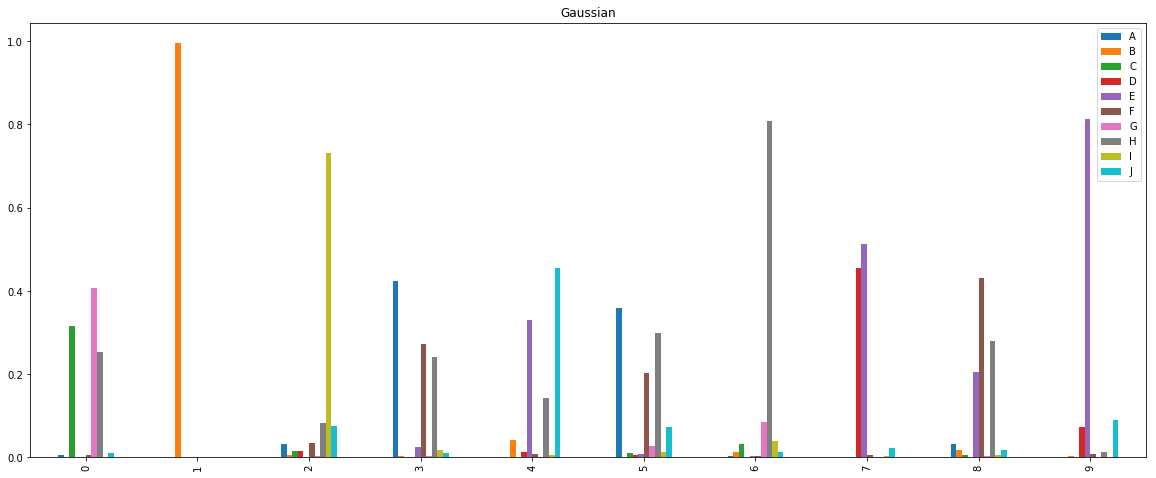

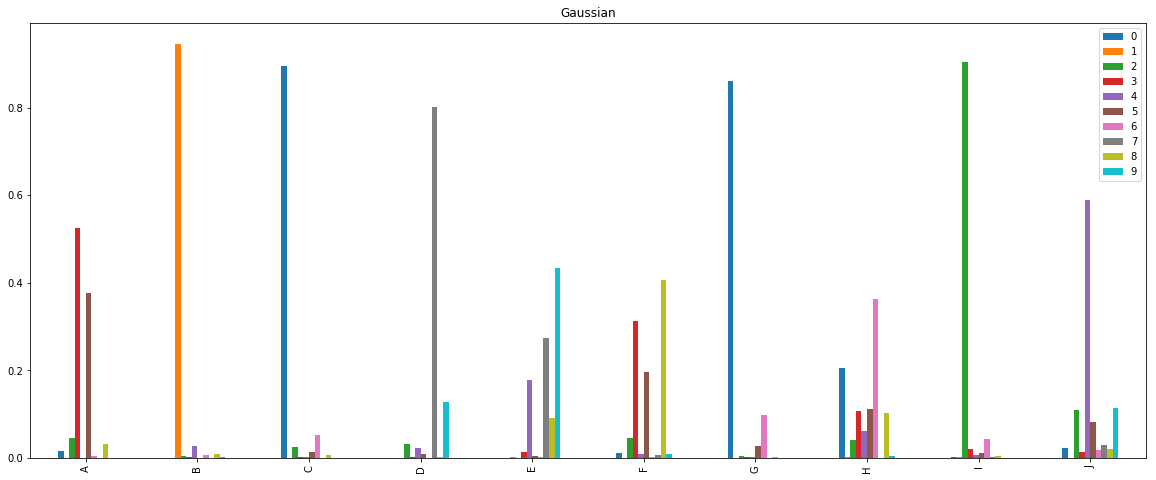

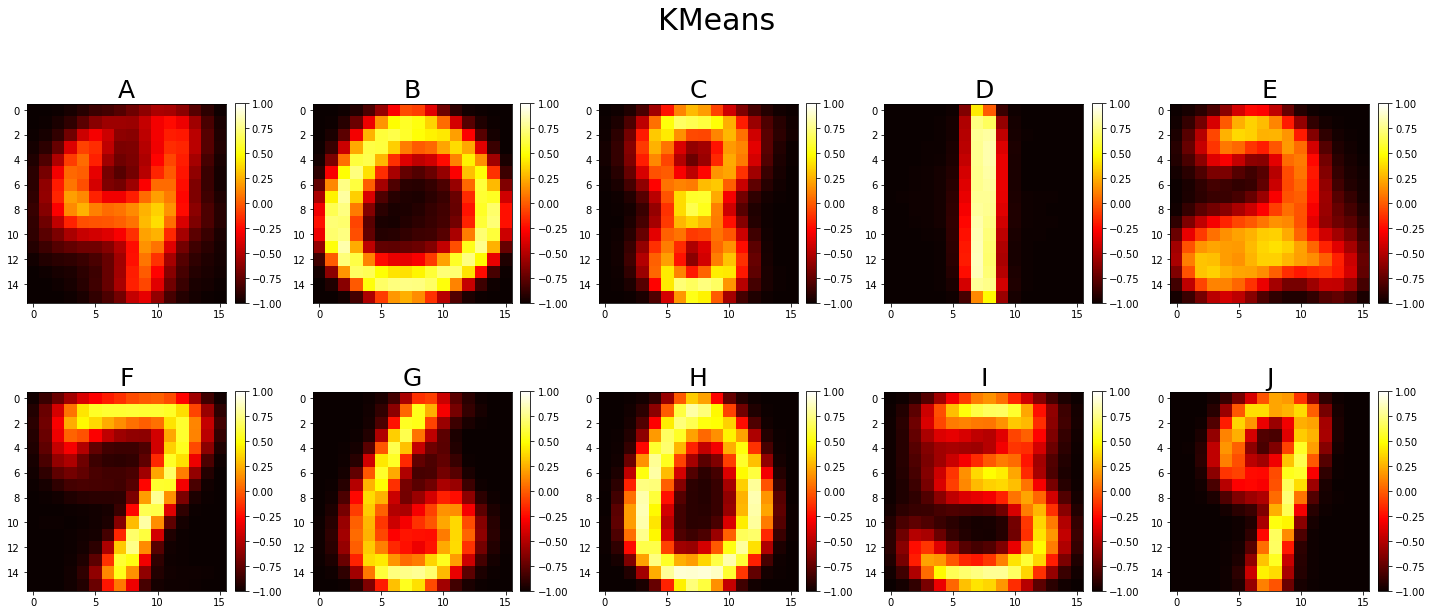

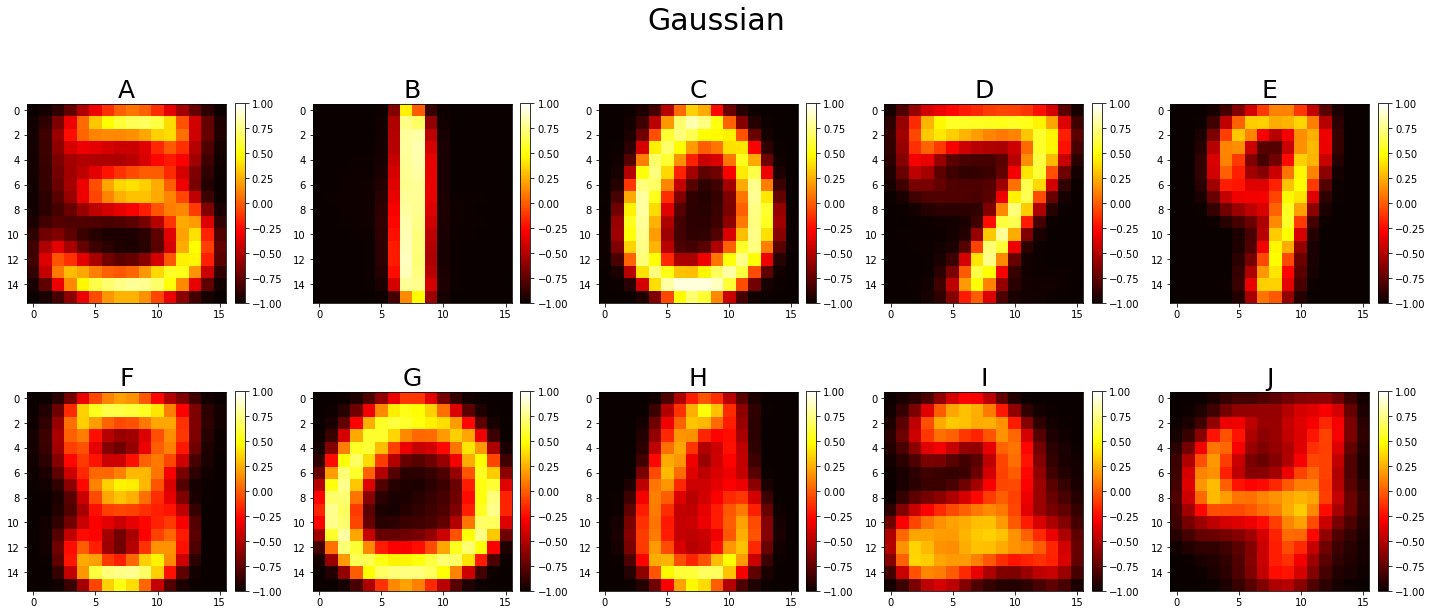

,KMeanslabel_correct
0,0.430486
1,0.995025
2,0.735978
3,0.826748
4,0.703988
5,0.000000
6,0.802711
7,0.680620
8,0.806273
9,0.698758


,Gaussianlabel_correct
0,0.314908
1,0.995025
2,0.730506
3,0.424012
4,0.455521
5,0.000000
6,0.808735
7,0.454264
8,0.431734
9,0.813665


In [14]:
# clustering adding a 'neighboring info' (local means of 4x4 subimages of each digit)
from skimage import transform

def add_neighbor_info(data):
    """does not take into account col 1 of data!!!
    creates new dataframe containing 16 additional columns with the local means of 4x4 imgs"""
    x = []
    for i in range(len(data)):
        img = pd.DataFrame(data.iloc[i,1:]).values.reshape(16,16)
        downscaled_img = transform.downscale_local_mean(img,(4,4)).flatten()
        x.append(downscaled_img)
    new_data = data.reset_index().iloc[:,1:]
    test3 = pd.concat([new_data,pd.DataFrame(x)],axis=1)
    test3.columns = range(test3.shape[1])
    return pd.DataFrame(test3)

nb_data = add_neighbor_info(data_train)
nb_data.head()
res2 = run_cluster_analysis(nb_data)
make_barplot("KMeans",res2)
make_barplot("Gaussian",res2)
print_subplots_all_clusters(nb_data,"KMeans","mean",res2)
print_subplots_all_clusters(nb_data,"Gaussian","mean",res2)
nb_K = display(calculate_correct_rates("KMeans",res2)[2])
nb_G = display(calculate_correct_rates("Gaussian",res2)[2])

orig_data                  nb          
                 KMeans  Gaussian    KMeans  Gaussian
0              0.432161  0.542714  0.430486  0.314908
1              0.996020  0.995025  0.995025  0.995025
2              0.772914  0.714090  0.735978  0.730506
3              0.831307  0.500000  0.826748  0.424012
4              0.674847  0.430982  0.703988  0.455521
5              0.000000  0.548561  0.000000  0.000000
6              0.804217  0.814759  0.802711  0.808735
7              0.688372  0.454264  0.680620  0.454264
8              0.793358  0.326568  0.806273  0.431734
9              0.687888  0.807453  0.698758  0.813665
Total correct  0.668108  0.613442  0.668059  0.542837

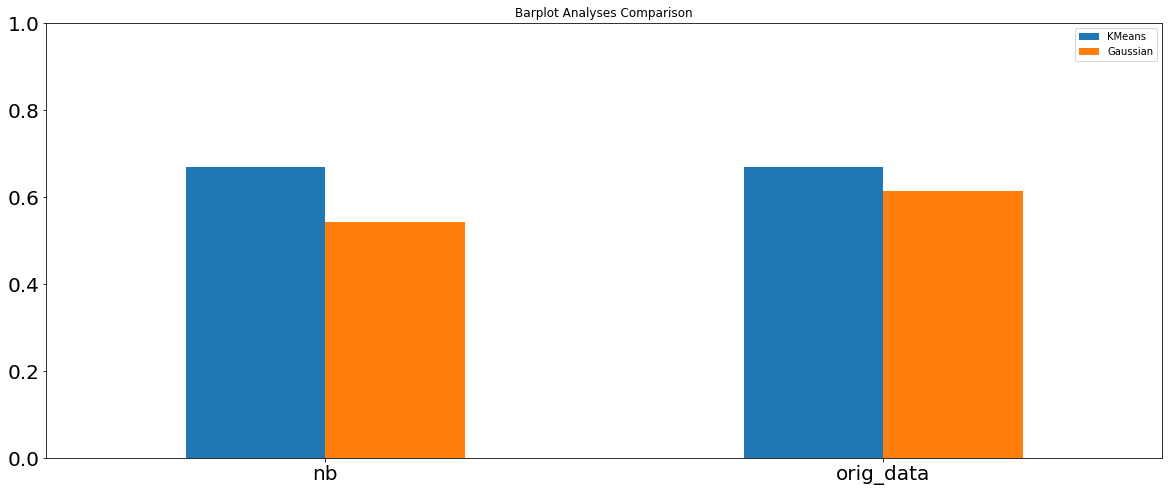

In [15]:
# comparing the correct rates when using orig data vs. neighboring info

def show_all_correct_rates(res_list,names_list):
    #analyses_names = ["orig_data","nb"]
    analyses_names = ["orig_data","nb"]
    rates = []
    
    for r in res_list:
        rates.append(calculate_correct_rates("KMeans",r)[2])
        rates.append(calculate_correct_rates("Gaussian",r)[2])
    #cols = [item + "\n" + other for item in analyses_names for other in ["KMeans","Gaussian"]]
    hierarch_names = [analyses_names,["KMeans","Gaussian"]]
    rates_df = pd.concat(rates,axis = 1)
    fancy_idx = pd.MultiIndex.from_product(hierarch_names)
    rates_df.columns = fancy_idx
    display(rates_df)
    rates_df.loc["Total correct"].unstack(1).plot(y= ["KMeans","Gaussian"],kind='bar',figsize=(20,8),rot=0,ylim=(0,1),title = "Barplot Analyses Comparison",fontsize=20)
    
show_all_correct_rates([res1,res2],['orig_data','nb'])

## Testing various supervised ML methods for classification of the digits

In [16]:
class Analysis: 
    """class that enables adding different input dataframes and algorithm configurations. Every input dataframe can then
    be analyzed using every algorithm by running the 'run_all_combis' function"""
    def __init__(self):
        self.results = pd.DataFrame() # contains the predicted ys
        self.input_data = {} # dict of dicts, contains the input data frames
        self.algo_names = [] # list of all algo names that were added
        self.algos = {} # dict of dicts, contains the algo names and algos
        self.analysis_summaries = {} # contains all analyses that have already been run and details about them 
                                        # (i.e. which algo and input data was used)
    
    def add_algo(self, algo, algo_name):
        """adds a new algo including its configurations (e.g. n_neighbors). Needs to be
        given a unique name"""
        if algo_name not in self.algo_names:
            self.algo_names.append(algo_name)
            self.algos[algo_name] = {'algo_name': algo_name, 'algo': algo}
        else: print("This algo config already exists!!")
    
    
    def add_input_prep(self, input_data_name, train_input_data, test_input_data):
        """accepts input data name, a train df and test df, scales both and stores them in
        input_data"""
        if input_data_name not in self.input_data:
            self.input_data[input_data_name] = {"train_data": train_input_data,\
                                               "test_data": test_input_data}
            #split in train and test
            self.input_data[input_data_name]["train_X"] = self.input_data[input_data_name]["train_data"].loc[:, self.input_data[input_data_name]["train_data"].columns != "target"]
            self.input_data[input_data_name]["test_X"] = self.input_data[input_data_name]["test_data"].loc[:, self.input_data[input_data_name]["test_data"].columns != "target"]
            self.input_data[input_data_name]["train_y"] = self.input_data[input_data_name]["train_data"].loc[:, self.input_data[input_data_name]["train_data"].columns == "target"].values.flatten()        
            self.input_data[input_data_name]["test_y"] = self.input_data[input_data_name]["test_data"].loc[:, self.input_data[input_data_name]["test_data"].columns == "target"].values.flatten()
            
            nr_features = self.input_data[input_data_name]["train_X"].shape[1]
            
            #standard scaling of continuous variables
            scaler = preprocessing.StandardScaler()
            train_df_cont = self.input_data[input_data_name]["train_X"]
            scaler.fit(train_df_cont) 
            self.input_data[input_data_name]["train_X"] = scaler.transform(train_df_cont)
            self.input_data[input_data_name]["test_X"] = scaler.transform(self.input_data[input_data_name]["test_X"])
            
            return self.input_data
            
        else:
            print("Input data name already exists!")
    
    def run_analysis(self,analysis_name,input_data_name,algo_name,):
        """runs an analysis with a given input_data df and algo_name. Calculates error rates and stores
        them in self.analysis_summaries. For LinReg, also calculates beta coefficients."""
        
        if analysis_name not in self.analysis_summaries:
            self.analysis_summaries[analysis_name] = {"input_data_name":input_data_name,"algo_name":algo_name,"fit":-1}
            
            # get the data from input_data
            train_X, test_X, train_y, test_y = self.input_data[input_data_name]["train_X"],\
                self.input_data[input_data_name]["test_X"],\
                self.input_data[input_data_name]["train_y"],\
                self.input_data[input_data_name]["test_y"]
            
            if self.analysis_summaries[analysis_name]['fit'] == -1:
                print("self analysis summary is -1")
                self.analysis_summaries[analysis_name]['fit'] = self.algos[algo_name]['algo'].fit(train_X, train_y) 
                pred = self.algos[algo_name]['algo'].predict(test_X)
                self.results[analysis_name] = pred 
                # error and r2 calculation
                mse= mean_squared_error(pred,test_y.flatten())
                rmse = np.sqrt(mse)
                self.analysis_summaries[analysis_name]["RMSE"] = rmse
                #R2 = self.analysis_summaries[analysis_name]['fit'].score(test_X, test_y)
                R2 = self.algos[algo_name]['algo'].score(test_X, test_y)
                r2_sc = r2_score(test_y,pred)
                self.analysis_summaries[analysis_name]["R2"] = r2_sc
                
                rss = (sum((pred - test_y)**2))
                tss = (sum((test_y.mean() - test_y)**2))
                r2_formel = 1-(rss/tss)
                rse = np.sqrt(rss/(test_X.shape[0]-test_X.shape[1]))
                self.analysis_summaries[analysis_name]["RSE"] = rse
                print(f"RSE: {rse}, RMSE: {rmse}, R2: {R2}, R2_score: {r2_sc},R2_formel: {r2_formel}")
                acc = (1.0*(test_y == pred.astype(int)).sum())/test_y.shape[0]
                print(f"acc: {acc}")
                self.analysis_summaries[analysis_name]["acc"] = acc
                if isinstance(self.algos[algo_name],linear_model.base.LinearRegression):
                    betas = self.analysis_summaries[analysis_name]['fit'].coef_
                    betas_df = pd.DataFrame(data = betas.reshape(1,train_X.shape[1]),columns = train_X.columns)
                    self.analysis_summaries[analysis_name]["betas"] = betas_df
                if isinstance(self.algos[algo_name]["algo"],linear_model.logistic.LogisticRegression):
                    probas = self.analysis_summaries[analysis_name]['fit'].predict_proba(test_X)
                    logloss = log_loss(test_y,probas)
                    self.analysis_summaries[analysis_name]["LogLoss"] = logloss
                    print(f"LogLoss: {logloss}")
                    print("Confusion Matrix:")
                    conf_matrix = confusion_matrix(test_y, pred)
                    display(conf_matrix)
                    #http://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html
                
                
        else: print("Analysis name already exists!")
    
    def run_all_combis(self):
        for i in self.input_data.keys():
            for a in self.algos:
                ananame = str(a) + "_" + str(i)
                print(f"\nRunning {ananame} analysis...")
                self.run_analysis(ananame,i,a)
                print("Finished!")
                      
    def calculate_error_rates(self):
        """returns a df with R2, RMSE and RSE for each analysis (i.e. each combination of 
        input_data and algo that was run with run_analysis)"""
        rates = pd.DataFrame(columns = ["Input DF","Algo Name","R2","RMSE","RSE"],index = self.analysis_summaries.keys())
        for ana in self.analysis_summaries:
            rates.loc[ana,"Input DF"] = self.analysis_summaries[ana]["input_data_name"]
            rates.loc[ana,"Algo Name"] = self.analysis_summaries[ana]["algo_name"]
            rates.loc[ana,"R2"] = self.analysis_summaries[ana]["R2"]
            rates.loc[ana,"RMSE"] = self.analysis_summaries[ana]["RMSE"]
            rates.loc[ana,"RSE"] = self.analysis_summaries[ana]["RSE"]
            rates.loc[ana,"ACC"] = self.analysis_summaries[ana]["acc"]
            if "LogLoss" in self.analysis_summaries[ana]:
                rates.loc[ana,"LogLoss"] = self.analysis_summaries[ana]["LogLoss"]
        #display(rates)
        return rates
    
    def pretty_barplots(self):
        "prints a barplot sumarizing the error rates and R2 for the analyses that were run before"
        pass
            
    def delete_input_data(self,input_data_name):
        self.input_data.pop(input_data_name,None) # None means nothing happens if key not found
        print(f"{input_data_name} was deleted")
        
    def get_results(self):
        return self.results
        

In [17]:
analysis = Analysis()

In [18]:
analysis.add_input_prep("orig",data_train,data_test)

{'orig': {'train_data':       target      1      2      3      4      5      6      7      8      9  \
  0        6.0 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000 -0.631  0.862   
  1        5.0 -1.000 -1.000 -1.000 -0.813 -0.671 -0.809 -0.887 -0.671 -0.853   
  2        4.0 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000   
  3        7.0 -1.000 -1.000 -1.000 -1.000 -1.000 -0.273  0.684  0.960  0.450   
  4        3.0 -1.000 -1.000 -1.000 -1.000 -1.000 -0.928 -0.204  0.751  0.466   
  5        6.0 -1.000 -1.000 -1.000 -1.000 -1.000 -0.397  0.983 -0.535 -1.000   
  6        3.0 -1.000 -1.000 -1.000 -0.830  0.442  1.000  1.000  0.479 -0.328   
  7        1.0 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000  0.510 -0.213   
  8        0.0 -1.000 -1.000 -1.000 -1.000 -1.000 -0.454  0.879 -0.745 -1.000   
  9        1.0 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000 -0.909  0.801   
  10       7.0 -1.000 -1.000 -1.000 -1.000 -1.000 -0.596  0.912  1.000  0.290   
  11  

In [19]:
analysis.add_algo(KNeighborsClassifier(n_neighbors=5), 'KNN_5')

In [20]:
analysis.add_algo(linear_model.LogisticRegression(class_weight='balanced', random_state=42, solver='newton-cg', multi_class='multinomial'), 'LogRegMultinomial') 

In [21]:
analysis.run_all_combis()


Running KNN_5_orig analysis...
self analysis summary is -1
RSE: 1.1905778967187908, RMSE: 1.112057394754292, R2: 0.9267563527653214, R2_score: 0.86420207438725,R2_formel: 0.8642020743872498
acc: 0.9267563527653214
Finished!

Running LogRegMultinomial_orig analysis...
self analysis summary is -1
RSE: 1.2661295162926314, RMSE: 1.1826262651023, R2: 0.9138016940707524, R2_score: 0.8464203153928327,R2_formel: 0.8464203153928325
acc: 0.9138016940707524
LogLoss: 0.5836436652383205
Confusion Matrix:


array([[346,   0,   2,   3,   3,   1,   1,   0,   2,   1],
       [  0, 251,   1,   3,   3,   0,   3,   1,   1,   1],
       [  3,   0, 170,   4,   8,   2,   0,   2,   9,   0],
       [  1,   0,   3, 148,   1,  10,   0,   1,   1,   1],
       [  3,   1,   6,   1, 174,   3,   2,   2,   2,   6],
       [  3,   0,   0,   7,   1, 144,   1,   1,   1,   2],
       [  1,   0,   5,   0,   2,   3, 158,   0,   1,   0],
       [  0,   0,   2,   2,   7,   0,   0, 133,   0,   3],
       [  7,   0,   4,   2,   1,   7,   0,   1, 143,   1],
       [  0,   1,   0,   0,   3,   1,   0,   2,   3, 167]])

Finished!


In [22]:
analysis.calculate_error_rates()

,Input DF,Algo Name,R2,RMSE,RSE,ACC,LogLoss
KNN_5_orig,orig,KNN_5,0.864202,1.11206,1.19058,0.926756,NaN
LogRegMultinomial_orig,orig,LogRegMultinomial,0.84642,1.18263,1.26613,0.913802,0.583644


# Identifying and removing outliers from the data

In [23]:
def outside_boundaries(myseries,lower,upper):
    """returns the number of elements of myseries which are outside the lower-upper range (lower and upper are also series)"""
    within_lims = myseries.between(lower,upper,inclusive=True)
    return myseries.shape[0] - sum(within_lims)

def identify_outlier_rows(data,digit,limit):
    """returns the image rows (=observations) for each digit which are very different from the other image rows. 
    Identifies image rows of a digit, where more than limit * pixels (limit ranges between 0 and 1) are outlier 
    pixels (outlier pixel = outside mean +- 2sd image values). E.g. if limit = 0.1 --> observations are identified 
    as outliers if 0.1 * 256 pixels are outside the mean +- 2sd range"""
    all_rows = get_digit_rows(data,digit).iloc[:,1:]
    nr_observations = all_rows.shape[0]
    nr_limit_pixels = limit * 256
    print(f"Nr of observations: {nr_observations}")
    print(f"If an observation (= a row of data) has more than {nr_limit_pixels} outlier pixels, it is identified as outlier observation")
    all_rows.columns = range(all_rows.shape[1]) # colnames müssen geändert werden, damit sie wieder von 0 bis ende gehen (statt bei 1 anzufangen)!
    #all_rows.index = range(nr_observations) 
    #display(all_rows)      
    mean_array = get_digit_stat_array(data,digit,"mean")
    sd_array = get_digit_stat_array(data,digit,"sd")
    upper_lim = pd.Series((mean_array + 2*sd_array).flatten()) # .flatten() and pd.Series reconvert the 16*16 array to a 256 Series
    lower_lim = pd.Series((mean_array - 2*sd_array).flatten())
    digit_nr_outlier_pixels = pd.Series(np.zeros(nr_observations))
    for i in range(0,nr_observations):
        digit_nr_outlier_pixels[i] = outside_boundaries(all_rows.iloc[i,:],lower_lim,upper_lim) 
    #print(f"Number of outlier pixels for each of the {nr_observations} observations: ")
    #display(digit_nr_outlier_pixels)
    which_row_is_outlier = digit_nr_outlier_pixels.gt(nr_limit_pixels)
    print(f"{sum(which_row_is_outlier)} outlier observations were identified for this digit.")
    infodf = pd.concat([lower_lim,pd.Series(mean_array.flatten()),upper_lim,all_rows.transpose()],axis=1)
    #with pd.option_context('display.max_rows', None, 'display.max_columns', 10): # shows the whole df 
        #display(infodf)
    which_row_is_outlier.index = all_rows.index
    return all_rows.loc[which_row_is_outlier]


display(identify_outlier_rows(data_train,1,0.15))

Nr of observations: 1005
If an observation (= a row of data) has more than 38.4 outlier pixels, it is identified as outlier observation
7 outlier observations were identified for this digit.


,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
917,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000,-1.000,-0.706,0.700,-0.640,...,-0.209,0.843,-0.508,-1.000,-1.000,-1.000,-1.000,-1.00,-1.0,-1.0
2047,-1.0,-1.0,-1.0,-1.0,-1.0,-0.991,0.631,0.999,0.943,-0.101,...,-1.000,-1.000,-0.321,0.785,-0.269,-1.000,-1.000,-1.00,-1.0,-1.0
4903,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000,-1.000,-1.000,-0.446,0.957,...,-0.301,0.301,0.143,-0.334,-0.334,-0.334,-0.334,-0.53,-1.0,-1.0
5748,-1.0,-1.0,-1.0,-1.0,-1.0,-0.764,0.643,0.691,-0.013,-0.991,...,-1.000,-0.493,0.538,0.540,-0.504,-1.000,-1.000,-1.00,-1.0,-1.0
5749,-1.0,-1.0,-1.0,-1.0,-1.0,-0.341,0.990,0.786,-0.141,-0.953,...,-0.575,0.476,0.828,-0.812,-1.000,-1.000,-1.000,-1.00,-1.0,-1.0
6738,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000,0.242,0.999,0.999,0.608,...,-1.000,-1.000,-0.811,0.201,0.717,-0.979,-1.000,-1.00,-1.0,-1.0
6963,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000,-1.000,-0.551,0.585,0.999,...,-0.021,0.999,0.999,0.999,0.999,0.183,-1.000,-1.00,-1.0,-1.0


Nr of observations: 1194
If an observation (= a row of data) has more than 38.4 outlier pixels, it is identified as outlier observation
8 outlier observations were identified for this digit.


,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
1125,-1.000,-1.000,-1.000,-1.000,-1.00,-1.000,-1.000,-1.000,-1.000,-1.0,...,-1.000,-1.000,-1.000,-1.000,-1.000,-1.0,-1.0,-1.0,-1.0,-1.0
1250,-1.000,-1.000,-1.000,-1.000,-1.00,-1.000,-1.000,-1.000,-1.000,-1.0,...,-1.000,-0.873,-0.757,-0.757,-0.906,-1.0,-1.0,-1.0,-1.0,-1.0
2208,-1.000,-1.000,-1.000,-1.000,-1.00,-1.000,-1.000,-1.000,-1.000,-1.0,...,-1.000,-1.000,-1.000,-1.000,-1.000,-1.0,-1.0,-1.0,-1.0,-1.0
2209,-1.000,-1.000,-1.000,-1.000,-1.00,-1.000,-1.000,-1.000,-1.000,-1.0,...,-1.000,-1.000,-1.000,-1.000,-1.000,-1.0,-1.0,-1.0,-1.0,-1.0
2526,-1.000,-1.000,-1.000,-1.000,-1.00,-1.000,-1.000,-1.000,-1.000,-1.0,...,-1.000,-1.000,-1.000,-1.000,-1.000,-1.0,-1.0,-1.0,-1.0,-1.0
2999,-1.000,-1.000,-1.000,-1.000,-1.00,-1.000,-1.000,-1.000,-1.000,-1.0,...,-1.000,-1.000,-1.000,-1.000,-1.000,-1.0,-1.0,-1.0,-1.0,-1.0
6878,0.638,0.708,0.708,0.708,0.47,0.137,-0.249,-0.434,-0.963,-1.0,...,0.708,0.708,0.175,-0.167,-0.832,-1.0,-1.0,-1.0,-1.0,-1.0
6890,-1.000,-1.000,-1.000,-1.000,-1.00,-1.000,-1.000,-1.000,-1.000,-1.0,...,-1.000,-1.000,-1.000,-1.000,-1.000,-1.0,-1.0,-1.0,-1.0,-1.0


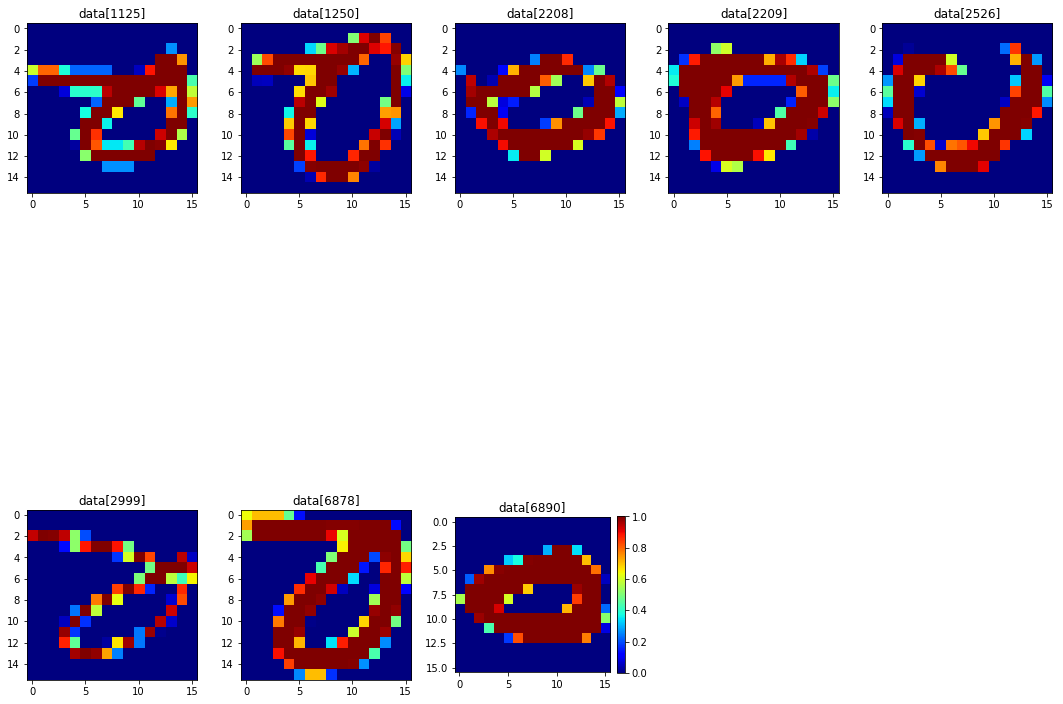

In [24]:
# showing outliers for a given digit

def print_outlier_images(data,digit,limit):
    """returns a plot showing the digit outlier observations for the chosen limit (limit ranges from 0-1). E.g. 
        if limit = 0.1, then an observation is considered as outlier if more than 256*0.1 = 25.6 pixels are outside 
        the mean +-2sd range. (I.e., the larger the limit, the less outliers are identified)"""
    fig = plt.figure(figsize=(15,15))
    ax = []
    rows = identify_outlier_rows(data,digit,limit) #dataframe with index = rownr in get_digit_rows
    display(rows)
    columns_figure = 5
    if not rows.empty:
        rows_figure = math.ceil(rows.shape[0]/columns_figure)
    else: return print("No outliers were found!")
    if rows.shape[0] > 50:
        print(f"There are {rows.shape[0]} outliers! Surely you don't want to see them all...")
        return None
    else:
        for i in range(0, rows.shape[0]):
            ax.append(fig.add_subplot(rows_figure, columns_figure, i+1))
            img = rows.iloc[i,:].values.reshape(16,16)
            indexlabel = rows.iloc[i].name
            datarow = get_digit_rows(data_train,digit).loc[indexlabel,:].name #finding the index of the row in the original data dataframe
            ax[i].set_title(f"data[{datarow}]")
            plt.imshow(img,cmap="jet",interpolation="nearest",vmin=0,vmax=1)
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.tight_layout()
        plt.show()

print_outlier_images(data_train,0,0.15)

In [25]:
def remove_all_outlier_rows(data,limit):
    data_new = data.copy()
    for digit in range(0,10):
        outliers = identify_outlier_rows(data,digit,limit)
        data_new = data_new.loc[data_new.index.difference(outliers.index)]
    return data_new

In [26]:
data_train.shape

(7291, 257)

In [27]:
cleaned_data_train = remove_all_outlier_rows(data_train,0.15)

Nr of observations: 1194
If an observation (= a row of data) has more than 38.4 outlier pixels, it is identified as outlier observation
8 outlier observations were identified for this digit.
Nr of observations: 1005
If an observation (= a row of data) has more than 38.4 outlier pixels, it is identified as outlier observation
7 outlier observations were identified for this digit.
Nr of observations: 731
If an observation (= a row of data) has more than 38.4 outlier pixels, it is identified as outlier observation
3 outlier observations were identified for this digit.
Nr of observations: 658
If an observation (= a row of data) has more than 38.4 outlier pixels, it is identified as outlier observation
17 outlier observations were identified for this digit.
Nr of observations: 652
If an observation (= a row of data) has more than 38.4 outlier pixels, it is identified as outlier observation
11 outlier observations were identified for this digit.
Nr of observations: 556
If an observation (= a

In [28]:
cleaned_data_train.shape

(7162, 257)

In [29]:
analysis.add_input_prep("no_outlier",cleaned_data_train,data_test)

{'orig': {'train_data':       target      1      2      3      4      5      6      7      8      9  \
  0        6.0 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000 -0.631  0.862   
  1        5.0 -1.000 -1.000 -1.000 -0.813 -0.671 -0.809 -0.887 -0.671 -0.853   
  2        4.0 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000   
  3        7.0 -1.000 -1.000 -1.000 -1.000 -1.000 -0.273  0.684  0.960  0.450   
  4        3.0 -1.000 -1.000 -1.000 -1.000 -1.000 -0.928 -0.204  0.751  0.466   
  5        6.0 -1.000 -1.000 -1.000 -1.000 -1.000 -0.397  0.983 -0.535 -1.000   
  6        3.0 -1.000 -1.000 -1.000 -0.830  0.442  1.000  1.000  0.479 -0.328   
  7        1.0 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000  0.510 -0.213   
  8        0.0 -1.000 -1.000 -1.000 -1.000 -1.000 -0.454  0.879 -0.745 -1.000   
  9        1.0 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000 -0.909  0.801   
  10       7.0 -1.000 -1.000 -1.000 -1.000 -1.000 -0.596  0.912  1.000  0.290   
  11  

In [30]:
analysis.add_algo(KNeighborsClassifier(n_neighbors=5), 'KNN_5')

This algo config already exists!!


In [31]:
analysis.run_all_combis()


Running KNN_5_orig analysis...
Analysis name already exists!
Finished!

Running LogRegMultinomial_orig analysis...
Analysis name already exists!
Finished!

Running KNN_5_no_outlier analysis...
self analysis summary is -1
RSE: 1.220189946921247, RMSE: 1.1397164832458824, R2: 0.9257598405580468, R2_score: 0.8573629363124742,R2_formel: 0.8573629363124738
acc: 0.9257598405580468
Finished!

Running LogRegMultinomial_no_outlier analysis...
self analysis summary is -1
RSE: 1.2376171353108671, RMSE: 1.1559943209009105, R2: 0.9108121574489287, R2_score: 0.8532594534676086,R2_formel: 0.8532594534676083
acc: 0.9108121574489287
LogLoss: 0.6014715145721343
Confusion Matrix:


array([[348,   0,   4,   2,   2,   1,   0,   0,   1,   1],
       [  0, 249,   1,   3,   4,   0,   4,   1,   1,   1],
       [  4,   0, 178,   3,   4,   3,   0,   1,   4,   1],
       [  1,   0,   6, 142,   1,  12,   1,   1,   1,   1],
       [  3,   1,   8,   0, 175,   2,   2,   1,   3,   5],
       [  5,   0,   0,   5,   1, 141,   2,   1,   3,   2],
       [  2,   0,   3,   0,   3,   4, 158,   0,   0,   0],
       [  0,   0,   2,   1,   9,   0,   0, 132,   1,   2],
       [  6,   0,   4,   3,   2,   6,   1,   1, 140,   3],
       [  0,   1,   0,   0,   6,   1,   0,   1,   3, 165]])

Finished!


In [32]:
analysis.calculate_error_rates().sort_values(["R2","RMSE"],ascending=[False,True])
# unfortunately, removing the outliers did not improve the classification

,Input DF,Algo Name,R2,RMSE,RSE,ACC,LogLoss
KNN_5_orig,orig,KNN_5,0.864202,1.11206,1.19058,0.926756,NaN
KNN_5_no_outlier,no_outlier,KNN_5,0.857363,1.13972,1.22019,0.925760,NaN
LogRegMultinomial_no_outlier,no_outlier,LogRegMultinomial,0.853259,1.15599,1.23762,0.910812,0.601472
LogRegMultinomial_orig,orig,LogRegMultinomial,0.84642,1.18263,1.26613,0.913802,0.583644


# Plotting ROC curves for binary case

In this example, digits 5 and 3 are picked from the dataset

In [33]:
all5_3_train = data_train[data_train["target"].isin([3,5])]
all5_3_test = data_test[data_test["target"].isin([3,5])]

In [34]:
all5_3_train.head()

,target,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
1,5.0,-1.0,-1.0,-1.0,-0.813,-0.671,-0.809,-0.887,-0.671,-0.853,...,-0.671,-0.671,-0.033,0.761,0.762,0.126,-0.095,-0.671,-0.828,-1.0
4,3.0,-1.0,-1.0,-1.0,-1.000,-1.000,-0.928,-0.204,0.751,0.466,...,0.466,0.639,1.000,1.000,0.791,0.439,-0.199,-0.883,-1.000,-1.0
6,3.0,-1.0,-1.0,-1.0,-0.830,0.442,1.000,1.000,0.479,-0.328,...,1.000,0.671,0.345,-0.507,-1.000,-1.000,-1.000,-1.000,-1.000,-1.0
26,3.0,-1.0,-1.0,-1.0,-1.000,-1.000,-0.104,0.549,0.579,0.579,...,0.388,0.579,0.811,1.000,1.000,0.715,0.107,-0.526,-1.000,-1.0
30,3.0,-1.0,-1.0,-1.0,-1.000,-1.000,-1.000,-0.107,1.000,1.000,...,-0.280,0.322,0.813,1.000,1.000,0.633,-0.144,-0.994,-1.000,-1.0


In [35]:
logreg = linear_model.LogisticRegression()
logreg.fit(all5_3_train.iloc[:,1:],all5_3_train.loc[:,"target"])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [36]:
probas_3 = logreg.predict_proba(all5_3_test.iloc[:,1:])[:,0]
probas_5 = logreg.predict_proba(all5_3_test.iloc[:,1:])[:,1]

In [37]:
logreg.classes_

array([3., 5.])

In [38]:
fpr, tpr, thresholds = roc_curve(all5_3_test["target"], probas_3, pos_label=3)

In [39]:
roc_auc_score(all5_3_test["target"]==3, probas_3)

0.9806099397590361

In [40]:
auc(fpr,tpr)

0.9806099397590361

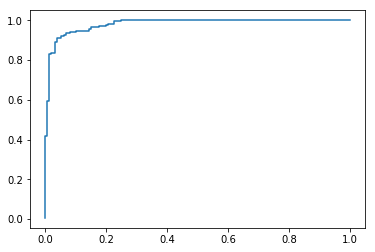

In [41]:
plt.plot(fpr, tpr, label='Target = 3')

In [42]:
fpr, tpr, thresholds = roc_curve(all5_3_test["target"], probas_5, pos_label=5)

In [43]:
roc_auc_score(all5_3_test["target"]==5, probas_5)

0.9806099397590361

In [44]:
auc(fpr,tpr)

0.9806099397590361

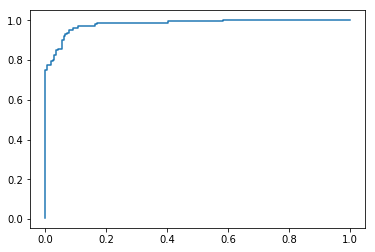

In [45]:
plt.plot(fpr, tpr, label='Target = 5')